In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from time import time
from agents import NStepSarsa
from agent_components import LinearSchedule, SigmoidSchedule, UpDownSchedule
from racetrack import RaceTrack, track_easy, track_hard, track_challenge, track_impossible
from parameter_study import ParameterStudy
from IPython.display import Image

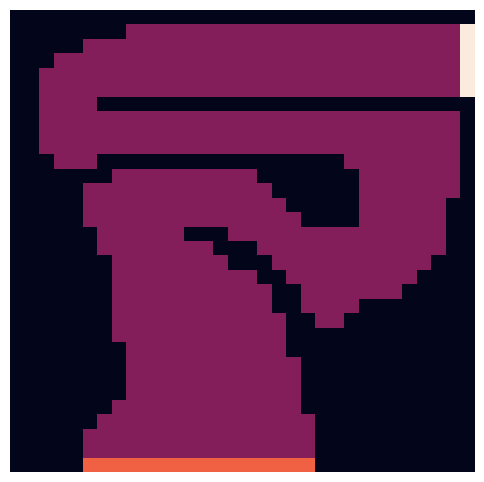

In [2]:
track = RaceTrack(track_impossible)
track.set_test()
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(track.track, ax=ax, cbar=False)
ax.axis('off')
plt.show()

In [3]:
n = 2
epsilon = 0.0
alpha = 0.5
discount = 1
num_states = track.num_states
num_actions = track.num_actions

eps_schedule = UpDownSchedule(epsilon, 0.02)
alp_schedule = LinearSchedule(alpha, 0.01)
agent = NStepSarsa(n,
                   epsilon,
                   alpha,
                   discount,
                   num_states,
                   num_actions,
                   eps_schedule,
                   alp_schedule,
                  )

In [4]:
agent.train(track, 100_000)

Episodes:   0%|          | 0/100000 [00:00<?, ?it/s]

Episode finished! Rendering animation...


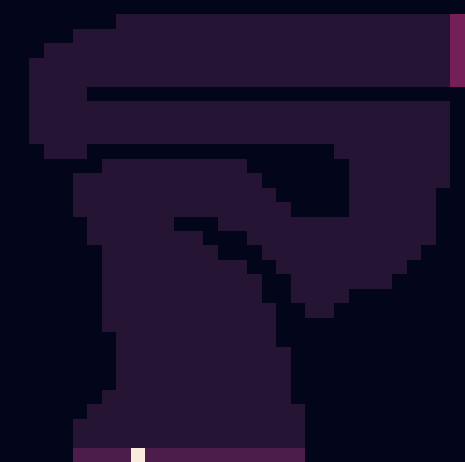

In [5]:
episode, _, _ = agent.play_episode(track, True, 100)
print("Episode finished! Rendering animation...")
name = "racetrack_testing"
track.render_episode(episode, name=name)
Image("animations/" + name + ".gif")

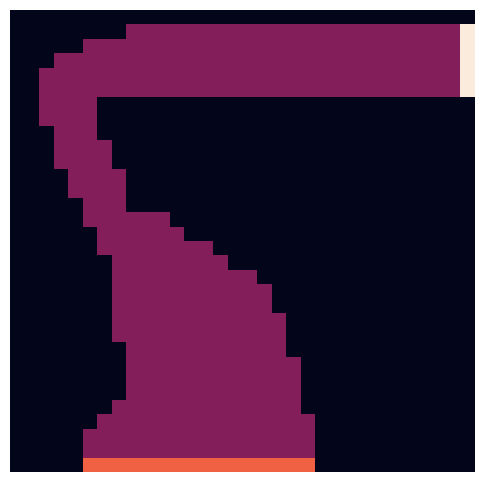

In [ ]:
track = RaceTrack(track_hard)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(track.track, ax=ax, cbar=False)
ax.axis('off')
plt.show()

agent_type = NStepSarsa
pd = {
    "epsilon": [0, 0.01, 0.02, 0.04],
    "alpha": [0.25, 0.375, 0.5, 0.625, 0.75],
    "n": [2],
    "discount": [1],
}

study = ParameterStudy(agent_type, track, pd)

num_runs = 10
num_episodes = 10_000
study.sweep(num_runs, num_episodes)

render_first = 2
filename = f"racetrack_param_sweeps/{int(time() // 60)}.png"
study.plot_results(render_first, filename)